# Learning-Based Compressive Subsampling


In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import fft, ifft, irfft, rfft
#from models import *
#from utils.denoising_utils import *

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs", torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

torch.set_printoptions(precision=4)

num GPUs 1


In [2]:
num_of_training = 1
image_size = 128

# Root directory for dataset
data_root = "./celebACroppedData/"



data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to (-1, 1) range
                           ]))

# shuffle data
random.seed(7)
img_lib = np.arange(1, len(data_set), 1)
random.shuffle(img_lib)

# training data
train_set = torch.utils.data.Subset(data_set, img_lib[:num_of_training])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

# validate specific images
val_set = torch.utils.data.Subset(data_set, img_lib[:num_of_training])
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

## Load target image

tensor(0.) tensor(0.9961)
torch.Size([1, 3, 128, 128])


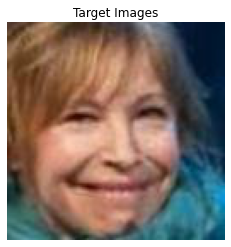

In [3]:
# dataloader = torch.utils.data.DataLoader(data_set, batch_size=64, shuffle=True, num_workers=2)

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Target Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].type(dtype)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
img_var = real_batch[0]
print(torch.min(img_var), torch.max(img_var))
print(img_var.shape)
img_np = var_to_np(img_var)
img_var = img_var.type(dtype)
output_depth = img_np.shape[0]

## Define forward model

In [4]:
X = img_var.reshape(-1, np.prod(img_var.shape) )
# X = img_var.view(-1, np.prod(img_var.shape) )
n = X.shape[1]
m = int(n/20)
A = torch.empty(n,m).normal_(0, 1).type(dtype)
A *= 1/np.sqrt(m)
print(m)

2457


In [5]:
def forwardm(img_var):
    X = img_var.reshape(-1 , np.prod(img_var.shape) )
    return torch.mm(X, A)
forwardm(img_var).shape

torch.Size([1, 2457])

In [6]:
# with a random mask
# mask = np_to_var(1.0*(np.random.randint(3, size=img_np_small.shape)<1)).type(dtype)
# def forwardm(img_var):
#     return img_var * mask

## DD reconstruction and helper functions

In [7]:
def get_net_input(num_channels,w=128,h=128):
    totalupsample = 2**len(num_channels)
    width = int(128/totalupsample)
    height = int(128/totalupsample)
    shape = [1,num_channels[0], width, height]
    net_input = Variable(torch.zeros(shape)).type(dtype)
    net_input.data.uniform_()
    net_input.data *= 1./10
    return net_input

def get_random_img(num_channels,ni=None):
    if ni is None:
        ni = get_net_input(num_channels)
    net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    print("generated random image with", num_channels, " network has ", num_param(net) )
    return net(ni)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='gray')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    plt.axis('off')    
    
def plot_img(img_ref): 
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure   
    ax1 = fig.add_subplot(231)
    ax1.imshow(img_ref,cmap='gray')
    #ax1.set_title('Original image')
    ax1.axis('off')
    
def init_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            #m.weight.data.uniform_()
            #torch.nn.init.xavier_uniform(m.weight)
            #nn.init.uniform_(m.weight)
            torch.nn.init.normal_(m.weight)

def snr(x_hat,x_true):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse= np.sum( np.square(x_hat-x_true) )
    #snr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    snr_ = mse / np.sum( np.square(x_true) )
    return snr_

In [8]:
def dd_recovery(measurement, img_var, num_channnels, num_iter=4000, apply_f=forwardm, ni=None):
    # net = decodernw(1,num_channels_up=num_channels,need_sigmoid=True).type(dtype)
    
    in_size = (16, 16)
    
    img_np = var_to_np(img_var)
    out_size = img_np.shape[1:]
    
    net = deepdecoder( in_size, out_size,
                output_depth,
                num_channels=num_channels,
                need_sigmoid=True,
                #need_tanh=True,
                last_noup=False,
               ).type(dtype)
    
    # net.apply(init_weights)
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        net_input=ni,
                        reg_noise_std=0.0,
                        num_iter=num_iter,
                        #OPTIMIZER='SGD',
                        #LR = 0.01, #LR = 0.005,
                        OPTIMIZER='adam',
                        LR = 0.005, #LR = 0.005,
                        img_noisy_var=measurement.type(dtype),
                        net=net, 
                        apply_f = apply_f,
                        img_clean_var=img_var.type(dtype),
                        upsample_mode='free',
                        in_size = in_size,
                        )
    print(num_param(net))
    out_img_var = net( ni.type(dtype) )
    return out_img_var, mse_n, mse_t

## Example reconstruction

In [9]:
#num_channels = [256]*4
#num_channels = [512]*5
num_channels = [256]*5
measurement = forwardm(img_var).type(dtype)
out_img_var, mse_n, mse_t = dd_recovery(measurement, img_var, num_channels)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  115.02572
orig img norm:  99.75675
optimize with adam 0.005
331008ion 03990    Train loss 0.000000  Actual loss 0.001588 Actual loss orig 0.001588 


In [10]:
print(measurement.shape, img_var.shape)

torch.Size([1, 2457]) torch.Size([1, 3, 128, 128])


0.08838155


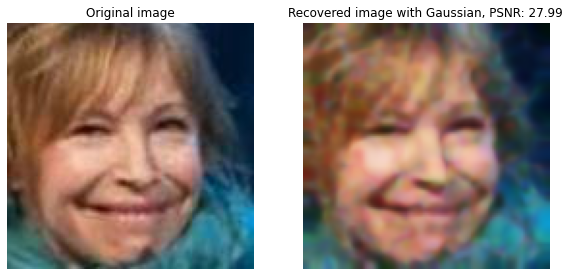

In [11]:
# orig_img = img_var.data.cpu().numpy()[0,0]
# rec_img = out_img_var.data.cpu().numpy()[0,0]
orig_img = img_var.data.cpu().numpy()[0]
rec_img = out_img_var.data.cpu().numpy()[0]

def show(plt, img):
#     plt.imshow(img, cmap='gray')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image with Gaussian, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [12]:
# define R_omega
img_size = img_var.shape[-1]
n = np.prod(img_var.shape)

c0 = np.zeros(n-m)
c1 = np.ones(m)
R_np = np.concatenate((c0, c1), axis=0)
random.shuffle(R_np)

R = np_to_var(R_np).type(dtype)
R = R.view(-1)
R.shape

torch.Size([49152])

In [13]:
# define sequence x, t (fixed throughout)
t = torch.normal(0, 1, size=(n, 1)).type(dtype)
t = torch.cat((t, torch.zeros(t.shape).type(dtype)), -1)

# random flip: d (fixed throughout)
d = torch.randint(2, (n, 1)) * 2 - 1
d = d.reshape(np.prod(d.shape) ).type(dtype)

def forward_circulant(img_var):
    x = img_var.reshape(np.prod(img_var.shape) )
    
    # flip signs
    x = d * x
    
    Cx = fft_circulant(x, t, dtype)
    RCx = R * Cx
    return RCx

forward_circulant(img_var).shape

torch.Size([49152])

In [14]:
num_channels = [256]*5
y = forward_circulant(img_var)
y

tensor([ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000, 35.8063],
       device='cuda:0')

In [15]:
out_img_var, mse_n, mse_t = dd_recovery(y.data, img_var, num_channels, apply_f=forward_circulant)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  114.60262
orig img norm:  99.75675
optimize with adam 0.005
331008ion 03990    Train loss 0.000151  Actual loss 0.001597 Actual loss orig 0.001597   


0.08867106


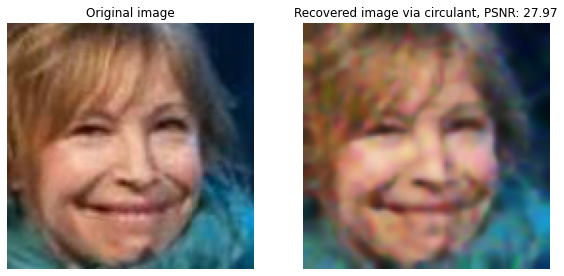

In [16]:
# orig_img = img_var.data.cpu().numpy()[0,0]
# rec_img = out_img_var.data.cpu().numpy()[0,0]
orig_img = img_var.data.cpu().numpy()[0]
rec_img = out_img_var.data.cpu().numpy()[0]

fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image via circulant, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [17]:
def vanilla_circulant(img_var):
    x = img_var.reshape(np.prod(img_var.shape)).type(dtype)

    # flip signs
#     x = d * x
    Cx = fft_circulant(x, t, dtype)
    return Cx

acc = torch.zeros(n).type(dtype)
for i, (train_img_var, _) in enumerate(train_loader):
    acc += vanilla_circulant(train_img_var) ** 2
    print(i)
    
acc_np = np.array(acc.cpu()).reshape(-1) 

top_m_i = np.argpartition(acc_np, -m)[-m:] 
R_learned_np = np.zeros(n)
R_learned_np[top_m_i] = 1
print(np.count_nonzero(R_learned_np))

0
2457


In [18]:
R_learned = np_to_var(R_learned_np).type(dtype)
R_learned = R_learned.view(-1)
R_learned.shape

torch.Size([49152])

In [19]:
np.sort(acc_np[np.nonzero(acc_np * R_learned_np)])

array([15282.286, 15282.857, 15284.016, ..., 34726.734, 34839.5  ,
       35643.61 ], dtype=float32)

In [20]:
torch.sort(acc[top_m_i])

torch.return_types.sort(
values=tensor([15282.2861, 15282.8574, 15284.0156,  ..., 34726.7344, 34839.5000,
        35643.6094], device='cuda:0'),
indices=tensor([   0,    1,    2,  ..., 2144, 1688, 1747], device='cuda:0'))

In [21]:
def learned_forward_circulant(img_var):
    x = img_var.reshape(np.prod(img_var.shape) )
    
    # flip signs
#     x = d * x
    Cx = fft_circulant(x, t, dtype)
    RCx_learned = R_learned * Cx
    return RCx_learned

In [22]:
num_channels = [256]*5
y = learned_forward_circulant(img_var)

print(torch.max(y**2), torch.min(y[torch.nonzero(y)]**2))

tensor(35643.6094, device='cuda:0') tensor(15282.2861, device='cuda:0')


In [23]:
m

2457

In [24]:
torch.nonzero(y).shape

torch.Size([2457, 1])

In [25]:
out_img_var, mse_n, mse_t = dd_recovery(y.data, img_var, num_channels, apply_f=learned_forward_circulant)

[(25, 25), (37, 37), (56, 56), (85, 85), (128, 128)]
input shape:  [1, 256, 16, 16]
init norm:  114.27243
orig img norm:  99.75675
optimize with adam 0.005
331008ion 03990    Train loss 0.138182  Actual loss 0.079608 Actual loss orig 0.079608   


0.51834816


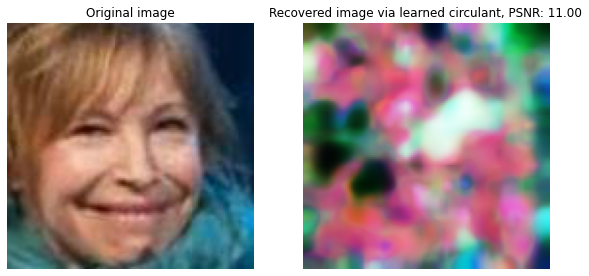

In [26]:
orig_img = img_var.data.cpu().numpy()[0]
rec_img = out_img_var.data.cpu().numpy()[0]

fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
show(ax1, orig_img) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(132)
show(ax2, rec_img)
ax2.set_title( "Recovered image via learned circulant, PSNR: %.2f" % psnr(orig_img, rec_img) )
ax2.axis('off') 

print( np.linalg.norm(orig_img /np.linalg.norm(orig_img) - rec_img/np.linalg.norm(rec_img)) )

In [42]:
y_ax = np.array(vanilla_circulant(img_var).cpu())
x_ax = np.arange(1, 49153)

No handles with labels found to put in legend.


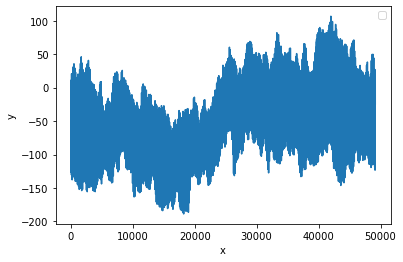

In [47]:
plt.plot(x_ax, y_ax)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()

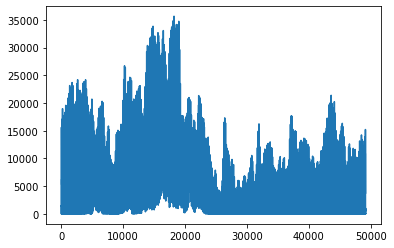

In [48]:
plt.plot(x_ax, y_ax**2)

In [41]:
y

tensor([-0., -0., -0.,  ..., -0., -0., -0.], device='cuda:0')